<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/NLP_Named%20Entity%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Named Entity Recognition

Named Entity Recognition refers to extracting "named entities" from the text. Named entities denote words in a sentence representing real-world objects with proper names like:

*   Person's names,
*   Countries and other geographical entities,
*   Organizations,

or anything that has been given a specific name.

In [ ]:
! pip install nerval > /dev/null

In [ ]:
! pip install sklearn_crfsuite > /dev/null

In [ ]:
! pip install torchcrf > /dev/null

In [ ]:
! pip install pytorch_transformers > /dev/null

In [ ]:
! pip install transformers > /dev/null

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import re
import string
import itertools
import matplotlib.pyplot as plt
import nltk
from pprint import pprint
from tqdm.auto import tqdm

from collections import Counter, OrderedDict

from sklearn_crfsuite import CRF
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

from sklearn.model_selection import cross_val_predict

from nerval import plot_confusion_matrix
from nerval import crm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

from torch.utils.data import DataLoader, TensorDataset, Dataset

from pytorch_transformers import BertPreTrainedModel, BertModel
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

from transformers import AdamW, AutoModelForTokenClassification, get_scheduler
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score

import spacy

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

Loading data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
FILE_PATH = "/content/drive/MyDrive/ds_data/NER/"

Mounted at /content/drive


In [ ]:
df = pd.read_csv(FILE_PATH + "ner_dataset.csv", encoding = 'unicode_escape')

### EDA

In [ ]:
df.head(25)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [ ]:
df.POS.unique()

array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
       'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
       'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
       'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
       'UH', 'FW'], dtype=object)

There are a few lines in the dataset with empty "Word" fields, so I remove them:

In [ ]:
df[df["Word"]=='\x85']

,Sentence #,Word,POS,Tag
1786,NaN,,",",O
219475,NaN,,",",O
219486,NaN,,",",O
434107,NaN,,:,O


In [ ]:
df = df[df.Word != '\x85']

For possible future use I prepared two dictionaries with POS codes and Named Entities tags and their descriptions:|

In [ ]:
pos_codes = {
      'CC':	'Coordinating conjunction',
	  	'CD':	'Cardinal number',
	  	'DT':	'Determiner',
		  'EX':	'Existential there',
	  	'FW':	'Foreign word',
	  	'IN':	'Preposition or subordinating conjunction',
	  	'JJ':	'Adjective',
	    'JJR':	'Adjective, comparative',
	  	'JJS':	'Adjective, superlative',
	  	'LS':	'List item marker',
	  	'MD':	'Modal',
		  'NN':	'Noun, singular or mass',
	  	'NNS':	'Noun, plural',
	  	'NNP':	'Proper noun, singular',
	  	'NNPS':	'Proper noun, plural',
	  	'PDT':	'Predeterminer',
	    'POS':	'Possessive ending',
	  	'PRP':	'Personal pronoun',
	  	'PRP$':	'Possessive pronoun',
	  	'RB':	'Adverb',
	  	'RBR':	'Adverb, comparative',
	  	'RBS':	'Adverb, superlative',
		  'RP':	'Particle',
	  	'SYM':	'Symbol',
	  	'TO':	'to',
	  	'UH':	'Interjection',
	  	'VB':	'Verb, base form',
	  	'VBD':	'Verb, past tense',
	  	'VBG':	'Verb, gerund or present participle',
	  	'VBN':	'Verb, past participle',
	  	'VBP':	'Verb, non-3rd person singular present',
	  	'VBZ':	'Verb, 3rd person singular present',
	  	'WDT':	'Wh-determiner',
    	'WP':	'Wh-pronoun',
	  	'WP$':	'Possessive wh-pronoun',
	  	'WRB':	'Wh-adverb'
}

In [ ]:
ne_tags = {
    'O': 'Not A Named Entity',
    'B-geo': 'Geographical Entity',
    'B-gpe': 'Geopolitical Entity',
    'B-per': 'Person',
    'I-geo': 'Geographical Entity',
    'B-org': 'Organization',
    'I-org': 'Organization',
    'B-tim': 'Time indicator',
    'B-art': 'Artifact',
    'I-art': 'Artifact',
    'I-per': 'Person',
    'I-gpe': 'Geopolitical Entity',
    'I-tim': 'Time indicator',
    'B-nat': 'Natural Phenomenon',
    'B-eve': 'Event',
    'I-eve': 'Event',
    'I-nat': 'Natural Phenomenon'
}

We have two tags for every type of named entities - "B-xxx" for the started word in a phrase or for a single named entity, and "I-xxx" for the following words in a phrase.

Let's check frequences for NE tags in our corpus:

In [ ]:
print("Number of tags: {}".format(len(df.Tag.unique())))
frequencies = df.Tag.value_counts()
frequencies

Number of tags: 17


O        887904
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

And also combined frequences of both B and I parts for every kind of proper names:

In [ ]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('geo', 45058), ('org', 36927), ('per', 34241), ('tim', 26861), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


Let's distribute the opening value for every sentence in the "Sentence #" column aiming to group by this field in the future:

In [ ]:
df['Sentence #'] = df['Sentence #'].fillna(method="ffill")

In [ ]:
df_gr = df.groupby('Sentence #').agg(lambda x: list(x))

In [ ]:
df['sent_id'] = df['Sentence #'].str.extract(r'\b(\w+)$', expand=True)
df['sent_id'] = df['sent_id'].astype(int)

So now I can group words by sentence ID and combine them into whole sentences. No doubt that this will be helpful later.

In [ ]:
df_full_sents = df.groupby('sent_id').agg({'Word' : ' '.join})

In [ ]:
df_full_sents.head()

,Word
sent_id,
1,Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
2,"Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as "" Bush Number One Terrorist "" and "" Stop the Bombings . """
3,They marched from the Houses of Parliament to a rally in Hyde Park .
4,"Police put the number of marchers at 10,000 while organizers claimed it was 1,00,000 ."
5,The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton .


In [ ]:
df_full_sents.rename(columns={'Word': 'sentence'}, inplace=True)

Prepare some statistics of word count in a given set of sentences and punctuation signs count:

In [ ]:
df_full_sents['word_count'] = df_full_sents['sentence'].str.split().apply(len)

In [ ]:
str = df_full_sents.iloc[3753]['sentence']
str

'The European rights court said the risk of a disturbance stemming from a demonstration was not sufficient to justify banning the parade .'

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

df_full_sents['count_punct'] = df_full_sents.sentence.apply(lambda s: count(s, string.punctuation))

In [ ]:
df_full_sents.count()

sentence       47959
word_count     47959
count_punct    47959
dtype: int64

In cumulative statistics, we see that the vast majority of sentences have no greater than 27 words per each (75 percentile), and the maximum number of words is 104. As for punctuation signs, there is a similar picture - 75% of sentences have 4 signs or less, and the maximum is 39:

In [ ]:
df_full_sents.describe()

,word_count,count_punct
count,"47,959.00","47,959.00"
mean,21.86,2.71
std,7.96,1.74
min,1.00,0.00
25%,16.00,1.00
50%,21.00,2.00
75%,27.00,4.00
max,104.00,39.00


In [ ]:
df_full_sents['length'] = df.groupby('sent_id').size()

In [ ]:
df = df.drop(['Sentence #'], axis=1)

Create a vocabulary with all words in the corpus:

In [ ]:
vocab = list(set(df["Word"].values))

In [ ]:
n_words = len(vocab)
n_words

35177

We have 35177 words used.

Here I define a class that provides a couple of methods to get sentences from the dataset in different formats which are needed for different algorithms that I will use below:

In [ ]:
class SentenceGetter(object):

    def __init__(self, data, output_type='TW'):
        self.n_sent = data["sent_id"].min()
        self.data = data
        self.empty = False
        if output_type=='TW':
          agg_func = lambda s: [(t, w) for t, w in zip(s["Tag"].values.tolist(),
                                                             s["Word"].values.tolist())]
        elif output_type=='WPT':
          agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                            s["POS"].values.tolist(),
                                                            s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("sent_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            self.empty = True
            return None

    def get_next_tagseq(self):
        try:
            s = self.data[self.data["sent_id"] == self.n_sent]
            self.n_sent += 1
            return s["Word"].values.tolist(), s["Tag"].values.tolist()
        except:
            self.empty = True
            return None, None

In [ ]:
getter = SentenceGetter(df)

In [ ]:
words = getter.get_next()
words

[('O', 'Thousands'),
 ('O', 'of'),
 ('O', 'demonstrators'),
 ('O', 'have'),
 ('O', 'marched'),
 ('O', 'through'),
 ('B-geo', 'London'),
 ('O', 'to'),
 ('O', 'protest'),
 ('O', 'the'),
 ('O', 'war'),
 ('O', 'in'),
 ('B-geo', 'Iraq'),
 ('O', 'and'),
 ('O', 'demand'),
 ('O', 'the'),
 ('O', 'withdrawal'),
 ('O', 'of'),
 ('B-gpe', 'British'),
 ('O', 'troops'),
 ('O', 'from'),
 ('O', 'that'),
 ('O', 'country'),
 ('O', '.')]

## Hidden Markov Model

This class template was given as a part of the homework. My task was to develop `fit` and `predict` methods using theory on HMM:

In [ ]:
class HMMTaggerTemplate():
    def __init__(self, states, observations):
        """Initialize HMM model with states and observations
        :param states: array with unique hidden states (list)
        :param observations: array with unique observations (list)
        """
        # add 'Unk' to handle unkown tokens
        self.states = states
        self.observations = [*observations, 'Unk']
        self.states_num = len(self.states)
        self.observations_num = len(self.observations)

        self.init_prob = np.zeros(shape=(1, self.states_num))
        self.transition_matrix = np.zeros(shape=(self.states_num,self.states_num))
        self.emission_matrix = np.zeros(shape=(self.states_num, self.observations_num))

        self.states_to_idx = {state:idx for idx, state in enumerate(self.states)}
        self.observations_to_idx = {obs:idx for idx, obs in enumerate(self.observations)}


    def fit(self, train_data):
        """Estimate initial probability vector, transition and emission matrices
        :param train_data: list of sentecnes where each sentence is represented by list of tuples (state, observation)

        Example: train_data = [[('O', 'Thousands'),
                                ('O', 'of'),
                                ('O', 'demonstrators'),
                                ('O', 'have'),
                                ('O', 'marched'),
                                ('O', 'through'),
                                ('B-geo', 'London')],
                               [('B-gpe', 'Iranian'),
                                ('O', 'officials'),
                                ('O', 'say'),
                                ('O', 'they'),
                                ('O', 'expect'),
                                ('O', 'to'),
                                ('O', 'get'),
                                ('O', 'access')]]

        """

        for sent in train_data:
          transitions = [self.states_to_idx[word[0]] for word in sent]
          for (i,j) in zip(transitions,transitions[1:]):
            self.transition_matrix[i][j] += 1

          for word in sent:
            self.emission_matrix[self.states_to_idx[word[0]]][self.observations_to_idx[word[1]]] += 1

          first_word = sent[0]
          self.init_prob[0][self.states_to_idx[first_word[0]]] += 1

        #convert transitions matrix to probabilities:
        for row in self.transition_matrix:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]

        #convert emission matrix to probabilities:
        for row in self.emission_matrix:
            s = sum(row) + self.observations_num
            if s > 0:
                row[:] = [(f+1)/s for f in row]

        #convert emission matrix to probabilities:
        for state_id in range(len(self.init_prob[0])):
            if self.init_prob[0][state_id] > 0:
                self.init_prob[0][state_id] = self.init_prob[0][state_id] / len(train_data)


    def __viterbi(self, obs_sequence_indices):
        """Decode incoming sequence of observations into the most propable sequence of hidden states using Viterbi algorithm
        : param obs_sequence_indices: list of observations indices
        :return: list of hidden states indices
        """
        tmp = [0]*self.states_num

        delta = [tmp[:]]  # Compute initial state probabilities
        for i in range(self.states_num):
          delta[0][i] = self.init_prob[0,i] * self.emission_matrix[i, obs_sequence_indices[0]]

        phi = [tmp[:]]

        for obs in obs_sequence_indices[1:]:  # For all observations except the inital one
          delta_t = tmp[:]
          phi_t = tmp[:]
          for j in range(self.states_num):   # Following formula 33 in Rabiner'89
            tdelta = tmp[:]
            tphimax = -1.0
            for i in range(self.states_num):
              tphi_tmp = delta[-1][i] * self.transition_matrix[i,j]
              if (tphi_tmp > tphimax):
                tphimax = tphi_tmp
                phi_t[j] = i
              tdelta[i] = tphi_tmp * self.emission_matrix[j, obs]
            delta_t[j] = max(tdelta)
          delta.append(delta_t)
          phi.append(phi_t)

        # Backtrack the path through the states  (Formula 34 in Rabiner'89)
        #
        tmax = -1.0
        for i in range(self.states_num):
          if (delta[-1][i] > tmax):
            tmax = delta[-1][i]
            state_seq = [i]  # Last state with maximum probability

        phi.reverse()  # Because we start from the end of the sequence
        for tphi in phi[:-1]:
          state_seq.append(tphi[state_seq[-1]])
        return reversed(state_seq)


    def predict(self, obser_seq):
        """Decode observable sequences using Viterbi algorithm
        :param obser_seq: list of sentences where each sentence is represented by list of observations
        :return: list of the most probable hidden states

        Example: obser_seq = [['The','military','says','the','blast'],
                              ['The','attack','prompted','Scandinavian','monitors','overseeing','Sri','Lanka']]
        """
        result = []
        if isinstance(obser_seq[0],list):
          for seq in obser_seq:
            id_seq =  [self.observations_to_idx[i] if i in self.observations else self.observations_to_idx['Unk'] for i in seq]
            result.append([list(self.states_to_idx.keys())[list(self.states_to_idx.values()).index(x)] for x in self.__viterbi(id_seq)])
        else:
          id_seq =  [self.observations_to_idx[i] if i in self.observations else self.observations_to_idx['Unk'] for i in obser_seq]
          result = [list(self.states_to_idx.keys())[list(self.states_to_idx.values()).index(x)] for x in self.__viterbi(id_seq)]

        return result


Tests

In [ ]:
states = ['A', 'B', 'C']
observ = ['x', 'y', 'z', 'u', 'v']
test_hmm = HMMTaggerTemplate(states, observ)
train_data = [[('A','x'),('B','y'),('A','u')],
              [('A','v'),('B','y'),('B','z'),('A','x'),('C','u')],
              [('C','u'),('B','x')]]
test_hmm.fit(train_data)

In [ ]:
test_hmm.transition_matrix

array([[0.        , 0.66666667, 0.33333333],
       [0.66666667, 0.33333333, 0.        ],
       [0.        , 1.        , 0.        ]])

In [ ]:
test_hmm.init_prob

array([[0.66666667, 0.        , 0.33333333]])

In [ ]:
test_hmm.emission_matrix

array([[0.3  , 0.1  , 0.1  , 0.2  , 0.2  , 0.1  ],
       [0.2  , 0.3  , 0.2  , 0.1  , 0.1  , 0.1  ],
       [0.125, 0.125, 0.125, 0.375, 0.125, 0.125]])

In [ ]:
print(test_hmm.predict(['x','y','u','v','z','x']))

['A', 'B', 'A', 'C', 'B', 'A']


In [ ]:
if not np.isclose(test_hmm.init_prob, np.array([[0.66666667, 0.        , 0.33333333]]), 1e-6).all():
  print('Initial probabilities are estimated incorrectly')

if not np.isclose(test_hmm.emission_matrix, np.array([[0.3  , 0.1  , 0.1  , 0.2  , 0.2  , 0.1  ],
                                                      [0.2  , 0.3  , 0.2  , 0.1  , 0.1  , 0.1  ],
                                                      [0.125, 0.125, 0.125, 0.375, 0.125, 0.125]]), 1e-6).all():
  print('Emission probabilities are estimated incorrectly')

if not np.isclose(test_hmm.transition_matrix, np.array([[0.        , 0.66666667, 0.33333333],
                                                        [0.66666667, 0.33333333, 0.        ],
                                                        [0.        , 1.        , 0.        ]]), 1e-6).all():
  print('Transition probabilities are estimated incorrectly')


if not test_hmm.predict(['x','y','u','v','z','x']) == ['A', 'B', 'A', 'C', 'B', 'A']:
  print('Decoding is incorrect')

###Training HMM and Inference

Auxiliary functions:

In [ ]:
def get_train_data(df, flag='TW'):
  # provides sentences in the format suitable for training the HMM:
  # [[(tag, word),(tag, word)...],...]
  getter = SentenceGetter(df, flag)
  return getter.sentences

In [ ]:
def get_test_data(df):
  # provides data suitable for testing - sentences and labels separately
  # [[words],[words]...] [[tags],[tags]...]
  sentences = []
  tags = []
  getter = SentenceGetter(df)
  sent, tag = getter.get_next_tagseq()
  while sent:
    sentences.append(sent)
    tags.append(tag)
    sent, tag = getter.get_next_tagseq()
  return sentences, tags

In [ ]:
def get_vocab(col):
  # provides a vocabulary of the given corpus
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    try:
      corpus += text
    except:
      print(text)
    corpus += ' '

  vocab = list(set(corpus.split()))

  return vocab

Train-test splitting:

In [ ]:
train_split = round(df_full_sents.shape[0]*0.8)
train_split

38367

In [ ]:
train_df = df_full_sents[:train_split]
test_df = df_full_sents[train_split:]

In [ ]:
train_vocab = get_vocab(train_df['sentence'])
test_vocab = get_vocab(test_df['sentence'])

In [ ]:
train_df = df.loc[(df['sent_id'] <= train_split)]
test_df = df.loc[(df['sent_id'] > train_split)]

In [ ]:
train_data = get_train_data(train_df)

In [ ]:
train_data[:1]

[[('O', 'Thousands'),
  ('O', 'of'),
  ('O', 'demonstrators'),
  ('O', 'have'),
  ('O', 'marched'),
  ('O', 'through'),
  ('B-geo', 'London'),
  ('O', 'to'),
  ('O', 'protest'),
  ('O', 'the'),
  ('O', 'war'),
  ('O', 'in'),
  ('B-geo', 'Iraq'),
  ('O', 'and'),
  ('O', 'demand'),
  ('O', 'the'),
  ('O', 'withdrawal'),
  ('O', 'of'),
  ('B-gpe', 'British'),
  ('O', 'troops'),
  ('O', 'from'),
  ('O', 'that'),
  ('O', 'country'),
  ('O', '.')]]

In [ ]:
len(train_data)

38367

In [ ]:
print(len(train_vocab), len(test_vocab))

31814 15930


In [ ]:
states = list(ne_tags.keys())

Instantiating and fitting the HMM model:

In [ ]:
hmm = HMMTaggerTemplate(states, train_vocab)

hmm.fit(train_data)

In [ ]:
%%time
test_data, test_tags = get_test_data(test_df)

CPU times: user 8.2 s, sys: 84.6 ms, total: 8.29 s
Wall time: 8.37 s


In [ ]:
test_data[:1]

[['In',
  'a',
  'letter',
  'to',
  'Egyptian',
  'President',
  'Hosni',
  'Mubarak',
  ',',
  'the',
  'New',
  'York-based',
  'Human',
  'Rights',
  'Watch',
  'said',
  'it',
  'was',
  'dismayed',
  'by',
  'what',
  'it',
  'called',
  'Cairo',
  "'s",
  '"',
  'radical',
  'intolerance',
  '"',
  'toward',
  'political',
  'dissent',
  '.']]

Predicting labels for test data:

In [ ]:
preds = hmm.predict(test_data)

In [ ]:
len(preds)

9592

In [ ]:
len(test_tags)

9592

For evaluating models performance I use `nerval` library which provide quite handy tools: entity-level confusion matrix and classification report designed specially for Named Entity Recognition (NER) models evaluation

In [ ]:
cr, cm, cm_labels = crm(test_tags, preds, scheme='BIO')

True Entities: 22478
Pred Entities: 20669 

True Entities with 3 or more tags: 2001
Pred Entities with 3 or more tags: 2034 

True positives:  16675
False positives (true = 'O'):  1562
False positives (true <> pred):  2432
ToT False positives:  3994
False negatives:  3371 



In [ ]:
print(cr)

              precision  recall  f1_score  true_entities  pred_entities
geo                0.83    0.86      0.84       7,552.00       7,804.00
tim                0.91    0.70      0.79       4,105.00       3,171.00
org                0.78    0.56      0.65       4,082.00       2,942.00
per                0.76    0.61      0.68       3,320.00       2,682.00
gpe                0.88    0.92      0.90       3,243.00       3,383.00
art                0.00    0.00      0.00          82.00           0.00
nat                0.00    0.00      0.00          48.00           0.00
eve                0.00    0.00      0.00          46.00           0.00
tim__              0.00    0.00      0.00           0.00         172.00
org__              0.00    0.00      0.00           0.00         184.00
geo__              0.00    0.00      0.00           0.00         102.00
gpe__              0.00    0.00      0.00           0.00           4.00
per__              0.00    0.00      0.00           0.00        

HMM model gives us f1-score = 0.78 which I assume is quite a good result for a baseline model.

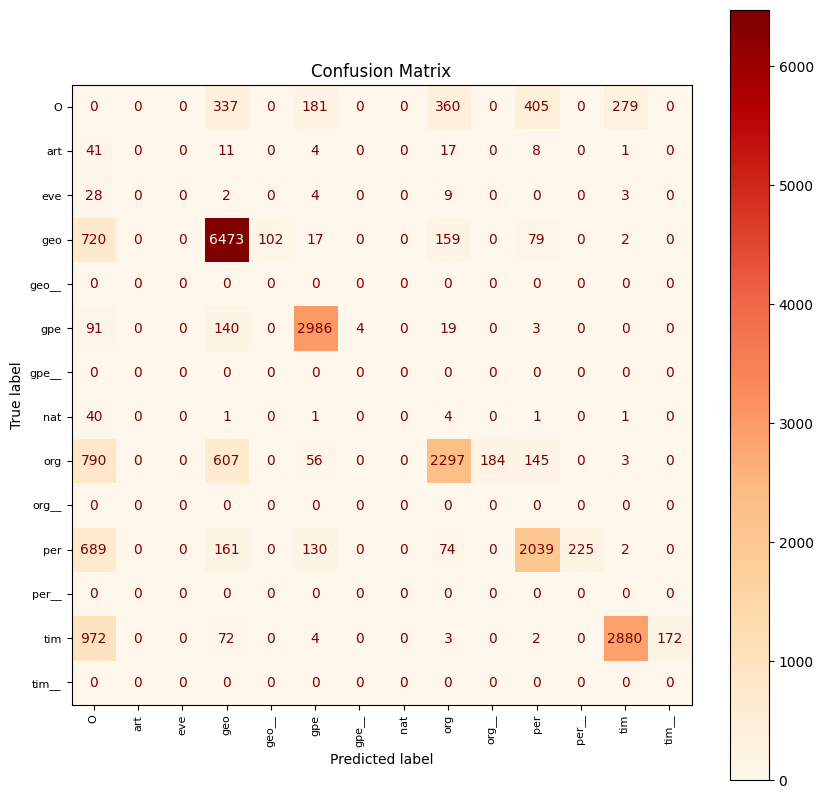

In [ ]:
plot_confusion_matrix(cm, cm_labels, show=True, save=False, img_path=None, normalize=None, decimal_places=2, figsize=(10,10), SMALL_SIZE=10, MEDIUM_SIZE=10, BIGGER_SIZE=12, cmap='OrRd', xticks_rotation='vertical', title='Confusion Matrix')

On the confusion matrix we see that most of predicted labels are on their places, but there are several big groups of false negatives: words that have named entity labels but labeled by our model as normal words (label 'O') and also false positives - words that got NER labels from the model but actually were normal words.

## Conditional Random Fields (CRF)

In [ ]:
train_data = get_train_data(train_df, 'WPT')
train_data[:1]

In [ ]:
len(train_data)

38367

Let’s extract more features (word parts, simplified POS tags, lower/title/upper flags, features of nearby words) and convert them to sklear-crfsuite format - each sentence should be converted to a list of dicts:

In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [ ]:
X_train = [sent2features(s) for s in train_data]
y_train = [sent2labels(s) for s in train_data]

This is how features extracted from a single sentence look like:

In [ ]:
X_train[:1]

[[{'bias': 1.0,
   'word.lower()': 'thousands',
   'word[-3:]': 'nds',
   'word[-2:]': 'ds',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   'postag': 'NNS',
   'postag[:2]': 'NN',
   'BOS': True,
   '+1:word.lower()': 'of',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'IN',
   '+1:postag[:2]': 'IN'},
  {'bias': 1.0,
   'word.lower()': 'of',
   'word[-3:]': 'of',
   'word[-2:]': 'of',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'postag': 'IN',
   'postag[:2]': 'IN',
   '-1:word.lower()': 'thousands',
   '-1:word.istitle()': True,
   '-1:word.isupper()': False,
   '-1:postag': 'NNS',
   '-1:postag[:2]': 'NN',
   '+1:word.lower()': 'demonstrators',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'NNS',
   '+1:postag[:2]': 'NN'},
  {'bias': 1.0,
   'word.lower()': 'demonstrators',
   'word[-3:]': 'ors',
   'word[-2:]': 'rs',
   'word.isupper()': F

Creating a CRF model using a class from `sklearn_crfsuite` module:  

In [ ]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

And training the model:

In [ ]:
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

In [ ]:
test_data = get_train_data(test_df, 'WPT')

In [ ]:
X_test = [sent2features(s) for s in test_data]
y_test = [sent2labels(s) for s in test_data]

Get predictions:

In [ ]:
pred = crf.predict(X_test)

In [ ]:
labels = list(crf.classes_)
labels.remove('O')

In [ ]:
metrics.flat_f1_score(y_test, pred,
                      average='weighted', labels=labels)

0.852512742664335

And build entity-level classification report:

In [ ]:
cr, cm, cm_labels = crm(y_test, pred, scheme='BIO')

True Entities: 22478
Pred Entities: 22101 

True Entities with 3 or more tags: 2001
Pred Entities with 3 or more tags: 2000 

True positives:  18854
False positives (true = 'O'):  1045
False positives (true <> pred):  2202
ToT False positives:  3247
False negatives:  1422 



In [ ]:
cr

,precision,recall,f1_score,true_entities,pred_entities
geo,0.86,0.90,0.88,"7,552.00","7,889.00"
tim,0.93,0.85,0.89,"4,105.00","3,744.00"
org,0.78,0.72,0.75,"4,082.00","3,771.00"
per,0.83,0.74,0.79,"3,320.00","2,963.00"
gpe,0.97,0.96,0.96,"3,243.00","3,202.00"
art,0.22,0.09,0.12,82.00,32.00
nat,0.71,0.50,0.59,48.00,34.00
eve,0.55,0.39,0.46,46.00,33.00
tim__,0.00,0.00,0.00,0.00,99.00
nat__,0.00,0.00,0.00,0.00,1.00


Utilising CRF we got f1-score = 0.85 that is much better than with HMM baseline.

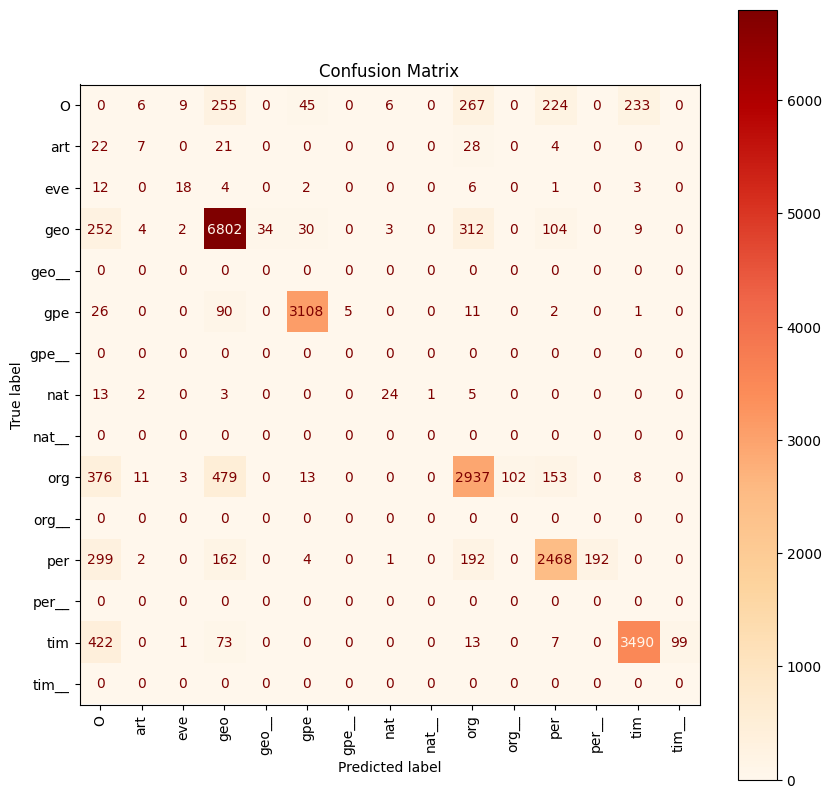

In [ ]:
plot_confusion_matrix(cm, cm_labels, show=True, save=False, img_path=None, normalize=None, decimal_places=2, figsize=(10,10), SMALL_SIZE=10, MEDIUM_SIZE=10, BIGGER_SIZE=12, cmap='OrRd', xticks_rotation='vertical', title='Confusion Matrix')

In the confusion matrix, we see that the number of false positives and false negatives is significantly lower than I got with the HMM model.

Let's investigate feature importance of the model. CRFsuite CRF models use two kinds of features: state features and transition features. Let’s check them:

In [ ]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

Here we can see that most likely and most unlikely transitions identified by CRF model:

In [ ]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top likely transitions:
B-geo  -> I-geo   9.175056
B-art  -> I-art   9.052101
B-tim  -> I-tim   8.963794
B-gpe  -> I-gpe   8.782180
I-tim  -> I-tim   8.203111
I-geo  -> I-geo   8.001469
I-art  -> I-art   7.731353
B-org  -> I-org   7.673058
B-nat  -> I-nat   7.621632
I-org  -> I-org   7.464875

Top unlikely transitions:
I-nat  -> O       -0.718867
I-tim  -> B-org   -0.781265
I-gpe  -> O       -0.833223
B-tim  -> B-gpe   -0.928626
I-gpe  -> B-geo   -1.238813
I-geo  -> B-gpe   -1.424938
I-org  -> B-geo   -1.452384
I-per  -> B-gpe   -1.910085
I-tim  -> B-gpe   -1.964938
I-per  -> B-geo   -2.109740


Transition features make sense: at least model learned that I-ENITITY must follow B-ENTITY. It also learned that some transitions are unlikely, e.g. it is not common in this dataset to have a location right after an organization name (I-ORG -> B-LOC has a large negative weight) or after a person.

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

We also can see which features are important for predicting a certain tag:

In [ ]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(20))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-20:])

Top positive:
8.192689 O        word.lower():last
8.152077 O        word.lower():month
7.187446 B-org    word.lower():philippine
7.067890 B-tim    word.lower():multi-candidate
6.901027 B-gpe    word.lower():niger
6.754992 B-gpe    word.lower():afghan
6.609476 B-org    word.lower():hamas
6.583954 B-org    word.lower():mid-march
6.551556 B-per    word.lower():president
6.399748 B-tim    word.lower():january
6.069975 B-tim    +1:word.lower():week
5.881783 B-gpe    word.lower():nepal
5.877188 B-tim    word.lower():weekend
5.803497 B-geo    word.lower():caribbean
5.780355 B-gpe    word[-3:]:pal
5.771965 B-tim    word.lower():august
5.754117 B-org    -1:word.lower():rice
5.688735 B-org    word.lower():al-qaida
5.680013 O        word.lower():chairman
5.664065 B-per    word.lower():obama

Top negative:
-3.431421 O        +1:word.lower():exact
-3.446375 O        +1:word.lower():mrs.
-3.463426 B-gpe    word.lower():european
-3.493368 I-org    -1:word.lower():minister
-3.550232 O        +1:word.l

##Bidirectional LSTM

Setting up device-agnostic code:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Defining some helper functions:

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix.keys() else to_ix[unk_tag] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [ ]:
def plot_train_progress(train_loss, train_acc, epochs):
    # Plots learning curves for the loss, and the metric (default - accuracy)

    epoch_count = [i for i in range(1,epochs+1)]
    m_name = 'Accuracy'


    plt.subplots(1, 2, figsize=(24, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count, train_loss, label="Train loss")
#    plt.plot(epoch_count, test_loss, label="Test loss")
    plt.grid(linestyle=':', color='k')
    plt.title("Training loss curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(epoch_count, train_acc, label="Train " + m_name )
#    plt.plot(epoch_count, test_acc, label="Test " + m_name)
    plt.grid(linestyle=':', color='k')
    plt.title("Training " + m_name + " curve")
    plt.ylabel(m_name)
    plt.xlabel("Epochs")
    plt.legend();
    plt.show()

In [ ]:
def model_save(model, name):
  # Saves models parameters

  # Create model save path
  MODEL_NAME = name
  MODEL_SAVE_PATH = FILE_PATH + MODEL_NAME

  # Save the model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

In [ ]:
def load_model(model_cls, name):
  # Loads model's parameters

  loaded_model_1 = model_cls

  MODEL_SAVE_PATH = FILE_PATH + name

  # Load model state dict
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

  # Put model to target device
  loaded_model_1.to(device)

  print(f"Loaded model:\n{loaded_model_1}")
  print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
  return loaded_model_1

Set hyperparameters for the model and training process:

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
pad_tag = "<pad>"
unk_tag = "<unk>"
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
EPOCHS = 1

Define the LSTM model

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

Define train and test sets. As the model is designed to handle single sentences not batches, we dont need to align all sentences to the one length:

In [ ]:
%%time
train_sents, train_tags = get_test_data(train_df)
test_sents, test_tags = get_test_data(test_df)

CPU times: user 55.7 s, sys: 260 ms, total: 56 s
Wall time: 56.4 s


In [ ]:
train_data = tuple(zip(train_sents, train_tags))

In [ ]:
train_sents[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

Define encoding dictionaries - `word_to_ix` and `tag_to_ix`:

In [ ]:
word_to_ix = {}
tag_to_ix = {}

for sentence, tags in train_data:
    for word in sentence:
      if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)

    for tag in tags:
      if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

# Add start and stop tags here
tag_to_ix[START_TAG] = len(tag_to_ix)
tag_to_ix[STOP_TAG] = len(tag_to_ix)

In [ ]:
tag_to_ix

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16,
 '<START>': 17,
 '<STOP>': 18,
 '<pad>': -100}

Instantiating the model and optimizer:

In [ ]:
lstm_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(lstm_model.parameters(), lr=0.01, weight_decay=1e-4)
lstm_model.to(device)
print(lstm_model)

BiLSTM_CRF(
  (word_embeds): Embedding(31814, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=19, bias=True)
)


Check predictions before training:

In [ ]:
with torch.inference_mode():
    precheck_sent = prepare_sequence(train_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_data[0][1]], dtype=torch.long)
    print(lstm_model(precheck_sent.to(device)))

(tensor(48.9314, device='cuda:0'), [1, 16, 11, 4, 14, 13, 1, 6, 4, 14, 13, 1, 6, 4, 14, 13, 1, 6, 4, 14, 13, 1, 6, 4])


In [ ]:
precheck_tags

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

As we can see model doesn't do well before training. So let's train it:

In [ ]:
%%time

counter = 0
print_every = 500
clip=5

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(EPOCHS):
    train_losses = []
    train_accs = []
    for sentence, tags in tqdm(train_data, total = len(train_data)):
        counter += 1
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        lstm_model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)

        score, y_pred = lstm_model(sentence_in)

        # Step 3. Run our forward pass.
        loss = lstm_model.neg_log_likelihood(sentence_in, targets)

        acc = metrics.flat_accuracy_score(targets.cpu().unsqueeze(0).tolist(), torch.Tensor(y_pred).unsqueeze(0).tolist())

        train_losses.append(loss.detach().cpu().float().numpy())
        train_accs.append(acc)
        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()

        nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)
        optimizer.step()
        if counter % print_every == 0:
          print("Epoch: {}/{}...".format(epoch+1, EPOCHS),
                          "Step: {}...".format(counter),
                          "Train Loss: {:.4f}...".format(np.mean(train_losses)), # loss.item()
                          "Train Accuracy: {:.4f}...".format(np.mean(train_accs)))
                          #"Val Loss: {:.4f}...".format(np.mean(val_losses)),
                          #"Val Accuracy: {:.4f}".format(np.mean(val_accs)))

  0%|          | 0/38367 [00:00<?, ?it/s]

Epoch: 1/1... Step: 500... Train Loss: 18.5120... Train Accuracy: 0.8508...
Epoch: 1/1... Step: 1000... Train Loss: 16.4201... Train Accuracy: 0.8560...
Epoch: 1/1... Step: 1500... Train Loss: 15.4583... Train Accuracy: 0.8564...
Epoch: 1/1... Step: 2000... Train Loss: 14.5615... Train Accuracy: 0.8579...
Epoch: 1/1... Step: 2500... Train Loss: 13.8003... Train Accuracy: 0.8610...
Epoch: 1/1... Step: 3000... Train Loss: 13.2279... Train Accuracy: 0.8633...
Epoch: 1/1... Step: 3500... Train Loss: 12.7500... Train Accuracy: 0.8664...
Epoch: 1/1... Step: 4000... Train Loss: 12.2839... Train Accuracy: 0.8686...
Epoch: 1/1... Step: 4500... Train Loss: 11.8809... Train Accuracy: 0.8710...
Epoch: 1/1... Step: 5000... Train Loss: 11.4271... Train Accuracy: 0.8743...
Epoch: 1/1... Step: 5500... Train Loss: 11.0419... Train Accuracy: 0.8769...
Epoch: 1/1... Step: 6000... Train Loss: 10.7215... Train Accuracy: 0.8791...
Epoch: 1/1... Step: 6500... Train Loss: 10.4531... Train Accuracy: 0.8815...


In [ ]:
plot_losses = []
plot_accs = []
num_points = len(train_data)%1000
prev=0
for i in range(num_points, len(train_data), num_points):
  avg_loss = sum(train_losses[prev:i])/num_points
  avg_acc = sum(train_accs[prev:i])/num_points
  plot_losses.append(avg_loss)
  plot_accs.append(avg_acc)
  prev += num_points

In [ ]:
len(plot_accs)

104

These are training curves for loss and accuracy:

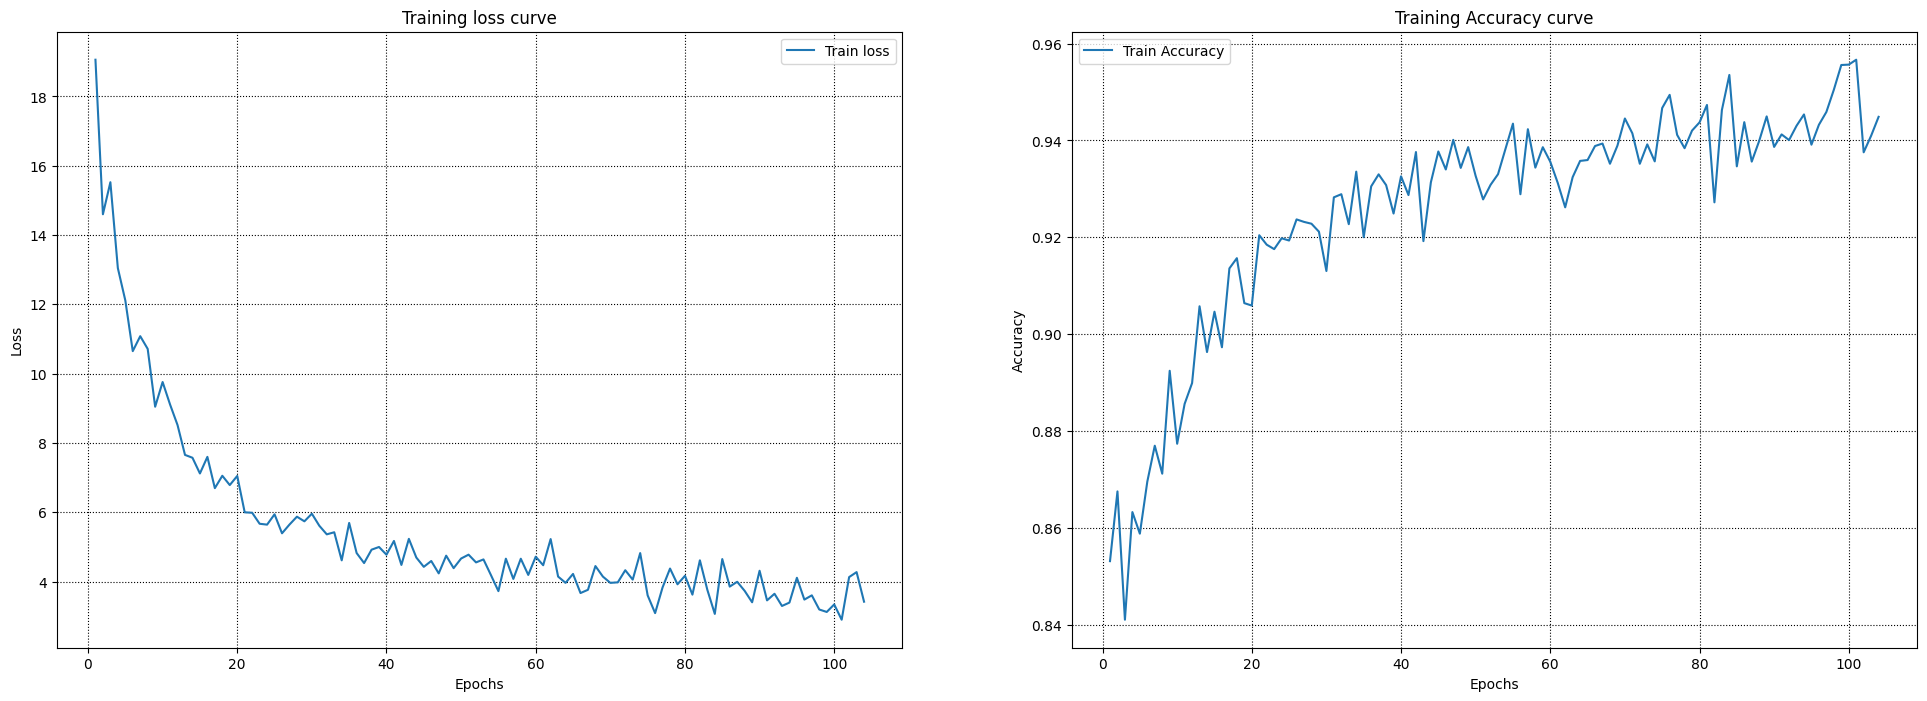

In [ ]:
plot_train_progress(plot_losses, plot_accs, 104)

Check how the model predicts after training:

In [ ]:
with torch.inference_mode():
    precheck_sent = prepare_sequence(test_sents[0], word_to_ix)
    print(lstm_model(precheck_sent.to(device)))

(tensor(319.1942, device='cuda:0'), [0, 0, 0, 0, 2, 3, 10, 10, 0, 0, 5, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
tag_id = []
for tag in test_tags[0]:
  tag_id.append(tag_to_ix[tag])
tag_id

[0,
 0,
 0,
 0,
 2,
 3,
 10,
 10,
 0,
 0,
 5,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

Looks good. Saving the model:

In [ ]:
model_save(lstm_model, 'ner_lstm_crf')

Saving model to: /content/drive/MyDrive/ds_data/NER/ner_lstm_crf


In [ ]:
lstm_model = load_model(BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM), 'ner_lstm_crf')

Loaded model:
BiLSTM_CRF(
  (word_embeds): Embedding(31814, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=19, bias=True)
)
Model on device:
cuda:0


Inference - doesn't works because of abcense of `<unk>` tag in word_to_ix dict :(

In [ ]:
with torch.inference_mode():
  preds = []
  for sent in test_sents:
    precheck_sent = prepare_sequence(sent, word_to_ix)
    prediction = lstm_model(precheck_sent.to(device))
    preds.append(prediction)
len(preds)

#### LSTM + CRF (attempt to upgrade)

Next section is my attempt to rewrite the LSTM class aimed to fix some drawbacks of the first approach - the inability to handle unknown words in testing data, and the inability to process mini-batches. Unfortunately, I was short on time so I couldn't manage to make it works.

Preprocessing + padding:

In [ ]:
word_to_ix = {}
tag_to_ix = {}

for sentence, tags in train_data:
    for word in sentence:
      if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)

    for tag in tags:
      if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

# Add start and stop tags here
tag_to_ix[START_TAG] = len(tag_to_ix)
tag_to_ix[STOP_TAG] = len(tag_to_ix)
tag_to_ix[pad_tag] = -100

word_to_ix[unk_tag] = 99999
word_to_ix[pad_tag] = 88888

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix.keys() else to_ix[unk_tag] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

Encoding the corpus of reviews in to list of Integer by using above dictionary:

In [ ]:
def encode_corpus(texts, vocab):
  encoded_texts=list()
  for text in texts:
    encoded_text = prepare_sequence(text, vocab)
    encoded_texts.append(encoded_text)
  return encoded_texts

Encoding sentences:

In [ ]:
encoded_train = encode_corpus(train_sents, word_to_ix)
encoded_test = encode_corpus(test_sents, word_to_ix)

In [ ]:
encoded_test[0]

tensor([  345,    45,  5114,     7,   351,   169,  7091,  7092,    93,     9,
         1379,  5006,  1798,  1799,  1800,   172,    58,    59, 16762,   191,
          570,    58,  1502,  3565,    68,    35,  2431,  5109,    35,   893,
          396,  8294,    21])

Encoding tag sequences:

In [ ]:
|encoded_train_tags = encode_corpus(train_tags, tag_to_ix)
encoded_test_tags = encode_corpus(test_tags, tag_to_ix)

In [ ]:
encoded_test_tags[0]

tensor([ 0,  0,  0,  0,  2,  3, 10, 10,  0,  0,  5,  6,  6,  6,  6,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Making all the encoded_review of the same length (padding shorter texts with <pad> words at the beginning of the text):

In [ ]:
def corpus_padding(texts, sequence_length, to_ix):
  features=np.ones((len(texts), sequence_length), dtype=int)
  for i, text in enumerate(texts):
    text = text.tolist()
    text_len=len(text)
    if (text_len<=sequence_length):
      pad=list(np.full(sequence_length-text_len, to_ix[pad_tag]))
      new=pad+text
    else:
      new=text[:sequence_length]
    features[i,:]=np.array(new)

  return torch.tensor(features, dtype=torch.long)

In [ ]:
X_train = corpus_padding(encoded_train, 104, word_to_ix)
X_test = corpus_padding(encoded_test, 104, word_to_ix)

In [ ]:
X_train[0]

tensor([88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
        88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
        88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
        88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
        88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
        88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
        88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
        88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888, 88888,
            0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,     9,    15,     1,    16,    17,
           18,    19,    20,    21])

In [ ]:
y_train = corpus_padding(encoded_train_tags, 104, tag_to_ix)
y_test = corpus_padding(encoded_test_tags, 104, tag_to_ix)

In [ ]:
y_train[0]

tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100,    0,    0,    0,    0,
           0,    0,    1,    0,    0,    0,    0,    0,    1,    0,    0,    0,
           0,    0,    2,    0,    0,    0,    0,    0])

In [ ]:
len(X_train)

9592

In [ ]:
len(y_train)

38367

Define torch datasets and dataloaders:

In [ ]:
#create Tensor Dataset
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

#dataloader
batch_size=100

train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class BiLSTM_CRF_2(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, batch_size, n_layers=1):
        super(BiLSTM_CRF_2, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.batch_size = batch_size
        self.n_layers = n_layers

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=n_layers, bidirectional=True, batch_first=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      print(torch.randn(self.n_layers * 2, self.batch_size, self.hidden_dim // 2).shape)
      return (torch.randn(self.n_layers * 2, self.batch_size, self.hidden_dim // 2).to(device),
              torch.randn(self.n_layers * 2, self.batch_size, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, x):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(x.long())
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(x), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, x):  # dont confuse this with _forward_alg above.
      batch_size=x.size()

      # Get the emission scores from the BiLSTM
      lstm_feats = self._get_lstm_features(x)

      # Find the best path, given the features.
      score, tag_seq = self._viterbi_decode(lstm_feats)
      return score, tag_seq

In [ ]:
tag_to_ix

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16,
 '<START>': 17,
 '<STOP>': 18,
 '<pad>': -100}

When I tried to instantiate the model I got the following error which is rather hard to interpret and fix:

In [ ]:
lstm_model2 = BiLSTM_CRF_2(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, batch_size, 1)
optimizer = optim.SGD(lstm_model2.parameters(), lr=0.01, weight_decay=1e-4)
lstm_model2.to(device)
print(lstm_model2)

torch.Size([2, 100, 128])


RuntimeError: ignored

In [ ]:
len(train_loader)

384

In [ ]:
%%time

counter = 0
print_every = 24
clip=5
EPOCHS = 2

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(EPOCHS):
    train_losses = []
    train_accs = []
    for sentence, tags in tqdm(train_loader, total = len(train_loader)):
        counter += 1
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        lstm_model2.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence = sentence.to(device)
        tags = tags.to(device)
        #targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)

        score, y_pred = lstm_model2(sentence)

        # Step 3. Run our forward pass.
        loss = lstm_model2.neg_log_likelihood(sentence, targets)

        acc = metrics.flat_accuracy_score(targets.cpu().unsqueeze(0).tolist(), torch.Tensor(y_pred).unsqueeze(0).tolist())

        train_losses.append(loss.detach().cpu().float().numpy())
        train_accs.append(acc)
        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()

        nn.utils.clip_grad_norm_(lstm_model2.parameters(), clip)
        optimizer.step()
        if counter % print_every == 0:
          print("Epoch: {}/{}...".format(epoch+1, EPOCHS),
                          "Step: {}...".format(counter),
                          "Train Loss: {:.4f}...".format(np.mean(train_losses)), # loss.item()
                          "Train Accuracy: {:.4f}...".format(np.mean(train_accs)))
                          #"Val Loss: {:.4f}...".format(np.mean(val_losses)),
                          #"Val Accuracy: {:.4f}".format(np.mean(val_accs)))

  0%|          | 0/384 [00:00<?, ?it/s]

RuntimeError: ignored

## BERT

BERT (Bidirectional Encoder Representations from Transformers) BERT is a neural network that utilizes transformer architecture whch is capable of parsing language in the same way a human does. It uses word embeddings to translate words into numbers and then back again, allowing it to understand word context and meaning.

Besides text classification, summarization, question answering and several other tasks, BERT can be used to solve NER problem.

In [ ]:
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Create dicts that help to encode and decode tag sequences:

In [ ]:
labels_to_ids = {k: v for v, k in enumerate(df.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(df.Tag.unique())}
labels_to_ids

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [ ]:
data = df_gr[["Word", "Tag"]].reset_index(drop=True)
data.head()

,Word,Tag
0,"[Thousands, of, demonstrators, have, marched, through, London, to, protest, the, war, in, Iraq, and, demand, the, withdrawal, of, British, troops, from, that, country, .]","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo, O, O, O, O, O, B-gpe, O, O, O, O, O]"
1,"[Iranian, officials, say, they, expect, to, get, access, to, sealed, sensitive, parts, of, the, plant, Wednesday, ,, after, an, IAEA, surveillance, system, begins, functioning, .]","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-tim, O, O, O, B-org, O, O, O, O, O]"
2,"[Helicopter, gunships, Saturday, pounded, militant, hideouts, in, the, Orakzai, tribal, region, ,, where, many, Taliban, militants, are, believed, to, have, fled, to, avoid, an, earlier, military, offensive, in, nearby, South, Waziristan, .]","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O, O, B-org, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo, O]"
3,"[They, left, after, a, tense, hour-long, standoff, with, riot, police, .]","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[U.N., relief, coordinator, Jan, Egeland, said, Sunday, ,, U.S., ,, Indonesian, and, Australian, military, helicopters, are, ferrying, out, food, and, supplies, to, remote, areas, of, western, Aceh, province, that, ground, crews, can, not, reach, .]","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo, O, B-gpe, O, B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O, O, O, O, O, O, O]"


Define pretrained BERT tokenizer and model hyperparameters:

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 100
VALID_BATCH_SIZE = 50
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Define dataset class which is aimed to take a row from the dataframe and prepare word sequence to be processed through BERT model (tokenizing, padding, truncating, assigning labels and attention masks):

In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = " ".join(self.data.Word[index])
        word_labels = self.data.Tag[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        encoding = self.tokenizer(sentence,
                             return_token_type_ids=False,
                             padding='max_length',
                             truncation=True,
                             max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels]
        encoded_labels = np.ones(len(encoding["input_ids"]), dtype=int) * -100

        word_n = 0
        for idx, token in enumerate(encoding.tokens()):
          if idx > 0 and word_n < len(self.data.Word[index]):
            word =  self.data.Word[index][word_n].lower()
            if (token == word) or (token != word and word.startswith(token)):
              encoded_labels[idx] = labels[word_n]
              word_n += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

  def __len__(self):
        return self.len

Dividing data into training and testing sets. Instantiating datasets using earlier created class:

In [ ]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (47959, 2)
TRAIN Dataset: (38367, 2)
TEST Dataset: (9592, 2)


In [ ]:
test_dataset.head()

,Word,Tag
0,"[Helicopter, gunships, Saturday, pounded, militant, hideouts, in, the, Orakzai, tribal, region, ,, where, many, Taliban, militants, are, believed, to, have, fled, to, avoid, an, earlier, military, offensive, in, nearby, South, Waziristan, .]","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O, O, B-org, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo, O]"
1,"[They, left, after, a, tense, hour-long, standoff, with, riot, police, .]","[O, O, O, O, O, O, O, O, O, O, O]"
2,"[U.N., relief, coordinator, Jan, Egeland, said, Sunday, ,, U.S., ,, Indonesian, and, Australian, military, helicopters, are, ferrying, out, food, and, supplies, to, remote, areas, of, western, Aceh, province, that, ground, crews, can, not, reach, .]","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo, O, B-gpe, O, B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O, O, O, O, O, O, O]"
3,"[Mr., Egeland, said, the, latest, figures, show, 1.8, million, people, are, in, need, of, food, assistance, -, with, the, need, greatest, in, Indonesia, ,, Sri, Lanka, ,, the, Maldives, and, India, .]","[B-per, I-per, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-tim, O, B-per, B-gpe, O, O, B-geo, O, B-geo, O]"
4,"[The, procedure, ,, known, as, cardiac, catheterization, ,, involves, inserting, a, catheter, through, a, blood, vessel, into, the, heart, ,, where, an, umbrella-like, device, will, plug, the, hole, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


Let's have a look on how peace of data looks like after preprocessing inside the `dataset` class:

---



In [ ]:
testing_set[0]

{'input_ids': tensor([  101,  7739,  4409, 19801,  5095, 13750, 16830, 29588,  2015,  1999,
          1996,  2030,  4817, 25290,  8807,  2555,  1010,  2073,  2116, 16597,
         17671,  2024,  3373,  2000,  2031,  6783,  2000,  4468,  2019,  3041,
          2510,  5805,  1999,  3518,  2148, 11333,  5831, 15061,  2319,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

Check if the dataset's `getitem` method correctli assigns NER labels to the BERT tokens:

In [ ]:
for token, label in zip(tokenizer.convert_ids_to_tokens(testing_set[0]["input_ids"]), testing_set[0]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
helicopter  0
guns        0
##hips      -100
saturday    7
pounded     0
militant    0
hideout     0
##s         -100
in          0
the         0
or          1
##ak        -100
##zai       -100
tribal      0
region      0
,           0
where       0
many        0
taliban     5
militants   0
are         0
believed    0
to          0
have        0
fled        0
to          0
avoid       0
an          0
earlier     0
military    0
offensive   0
in          0
nearby      0
south       1
wa          4
##zi        -100
##rist      -100
##an        -100
.           0
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]   

In [ ]:
for i in range(len(training_set)):
  for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[i]["input_ids"]), training_set[i]["labels"]):
    pass

Defining dataloaders that aimed to provide chunks of certain size (batches) of data to the model:

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
len(training_loader)

384

Instantiating the model and sending it to the available device - GPU or CPU:

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

Check if the model works and outputs some data:

In [ ]:
inputs = training_set[5]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(2.9862, device='cuda:0', grad_fn=<NllLossBackward0>)

...of certain shape:

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 17])

Defining the optimizer:

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

Defining a function for a training loop:

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    counter = 0
    print_every = 12
    # put model in training mode
    model.train()

    for batch in tqdm(training_loader, total = len(training_loader)):
        counter +=1
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs[0]
        tr_logits = outputs[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)

        if counter % print_every==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per {print_every} training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

And starting training:

In [ ]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1


  0%|          | 0/384 [00:00<?, ?it/s]

Training loss per 12 training steps: 2.183833589156469
Training loss per 12 training steps: 1.598457691570123
Training loss per 12 training steps: 1.3110673841502931
Training loss per 12 training steps: 1.133297289411227
Training loss per 12 training steps: 1.010363229115804
Training loss per 12 training steps: 0.9202270358800888
Training loss per 12 training steps: 0.8496332633353415
Training loss per 12 training steps: 0.7906946887572607
Training loss per 12 training steps: 0.7418985965627211
Training loss per 12 training steps: 0.6992821387946606
Training loss per 12 training steps: 0.6635073016990315
Training loss per 12 training steps: 0.6314700446608994
Training loss per 12 training steps: 0.6028061757485071
Training loss per 12 training steps: 0.5777910564626966
Training loss per 12 training steps: 0.5543136643866698
Training loss per 12 training steps: 0.533190930650259
Training loss per 12 training steps: 0.5146900732435432
Training loss per 12 training steps: 0.49736051047565

Function for validation:

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    eval_losses, eval_accs = [], []
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    counter = 0
    print_every = 12
    with torch.inference_mode():
          for batch in tqdm(testing_loader, total = len(testing_loader)):
            counter +=1

            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)

            if counter % print_every==0:
                loss_step = eval_loss/nb_eval_steps
                acc_step = eval_accuracy/nb_eval_steps
                print(f"Validation loss per {print_every} evaluation steps: {loss_step} ... validation accuracy: {acc_step}")
                eval_losses.append(loss_step)
                eval_accs.append(acc_step)

            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_losses, eval_accs

Validation process:

In [ ]:
labels, predictions, eval_losses, eval_accs = valid(model, testing_loader)

  0%|          | 0/192 [00:00<?, ?it/s]

Validation loss per 12 evaluation steps: 0.14482570750017962 ... validation accuracy: 0.8784859806340313
Validation loss per 12 evaluation steps: 0.15475326714416346 ... validation accuracy: 0.9163134893585246
Validation loss per 12 evaluation steps: 0.15375403045780128 ... validation accuracy: 0.930379753579612
Validation loss per 12 evaluation steps: 0.15678551187738776 ... validation accuracy: 0.9360488608853038
Validation loss per 12 evaluation steps: 0.15718771889805794 ... validation accuracy: 0.9398436924246024
Validation loss per 12 evaluation steps: 0.15933176399105126 ... validation accuracy: 0.9424594068797736
Validation loss per 12 evaluation steps: 0.16056294224801518 ... validation accuracy: 0.9438567951494292
Validation loss per 12 evaluation steps: 0.15859731558399895 ... validation accuracy: 0.9455570013570087
Validation loss per 12 evaluation steps: 0.15714165119937173 ... validation accuracy: 0.946984772449662
Validation loss per 12 evaluation steps: 0.15690012915680

Validation loss and accuracy curves (unfortunately, I forgot to collect values of these metrics during the training process so I can't build such plots for the training without restarting the process which was rather time-consuming.)

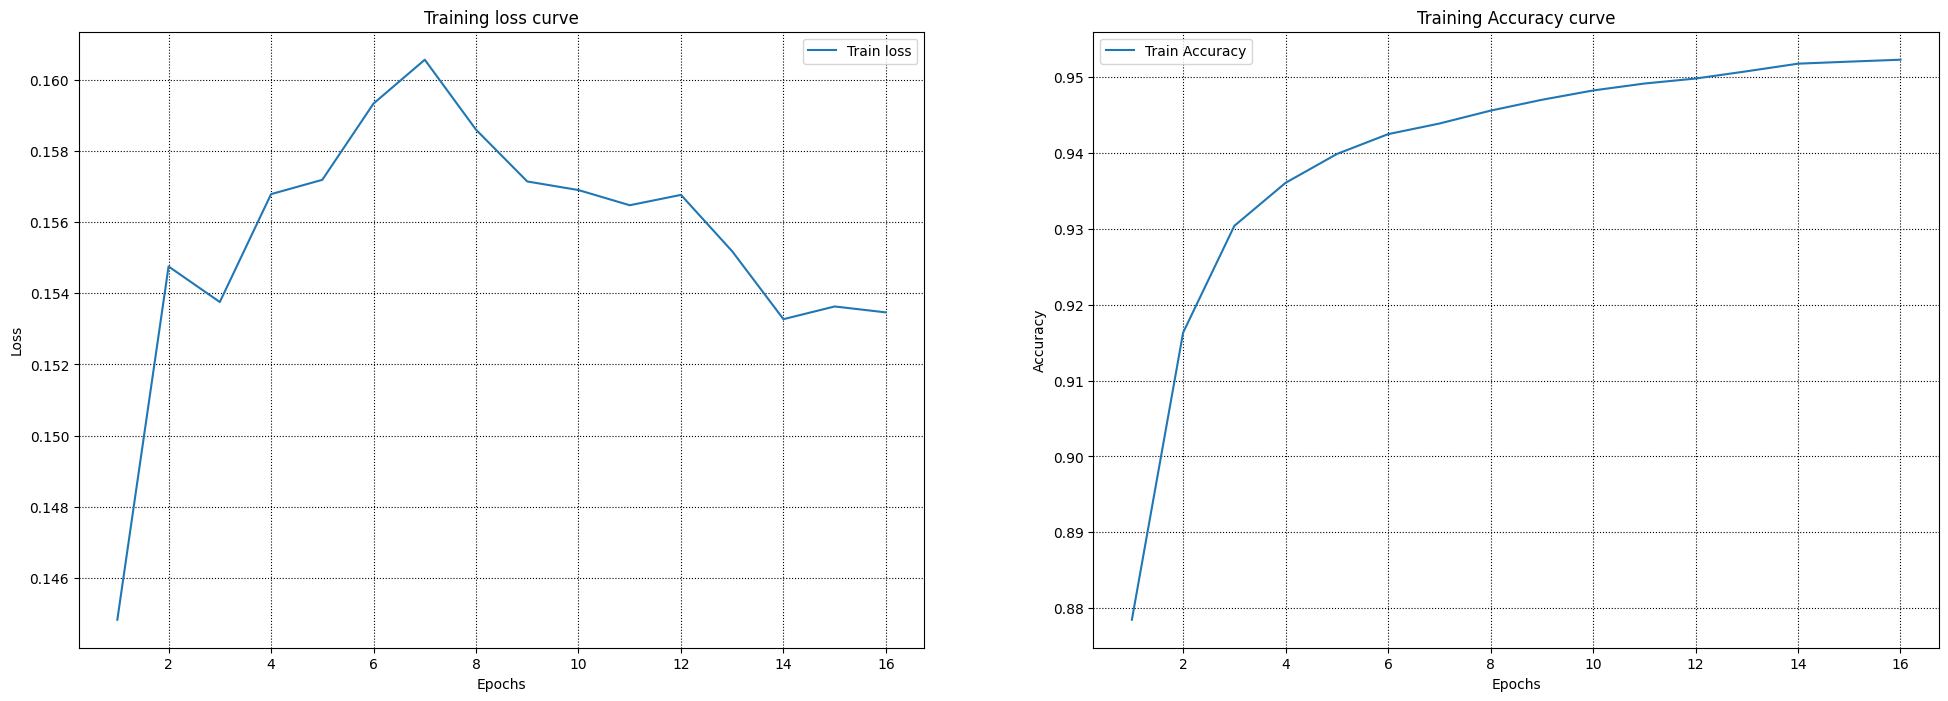

In [ ]:
plot_train_progress(eval_losses, eval_accs, 16)

Classification report:

In [ ]:
cr, cm, cm_labels = crm(labels, predictions, scheme='BIO')

Dataset was in the wrong shape: flat list.
It has been converted into the correct shape: list of flat lists. 

************************************************************************************************************************
Dataset was in the wrong shape: flat list.
It has been converted into the correct shape: list of flat lists. 

************************************************************************************************************************
True Entities: 22390
Pred Entities: 23116 

True Entities with 3 or more tags: 2006
Pred Entities with 3 or more tags: 1987 

True positives:  17245
False positives (true = 'O'):  2376
False positives (true <> pred):  3495
ToT False positives:  5871
False negatives:  1650 



In [ ]:
print(cr)

              precision  recall  f1_score  true_entities  pred_entities
geo                0.78    0.88      0.82       7,441.00       8,356.00
tim                0.84    0.82      0.83       4,102.00       3,973.00
org                0.64    0.51      0.56       4,029.00       3,211.00
per                0.78    0.76      0.77       3,495.00       3,377.00
gpe                0.90    0.86      0.88       3,116.00       3,004.00
art                0.00    0.00      0.00          91.00           0.00
eve                0.00    0.00      0.00          63.00           0.00
nat                0.00    0.00      0.00          53.00           0.00
geo__              0.00    0.00      0.00           0.00         260.00
tim__              0.00    0.00      0.00           0.00         264.00
org__              0.00    0.00      0.00           0.00         291.00
gpe__              0.00    0.00      0.00           0.00          89.00
per__              0.00    0.00      0.00           0.00        

Surprisingly with fine-tuned BERT I got worse result than with CRF model. F1-score is only 0.77 here. Will investigate later how to improve the result.

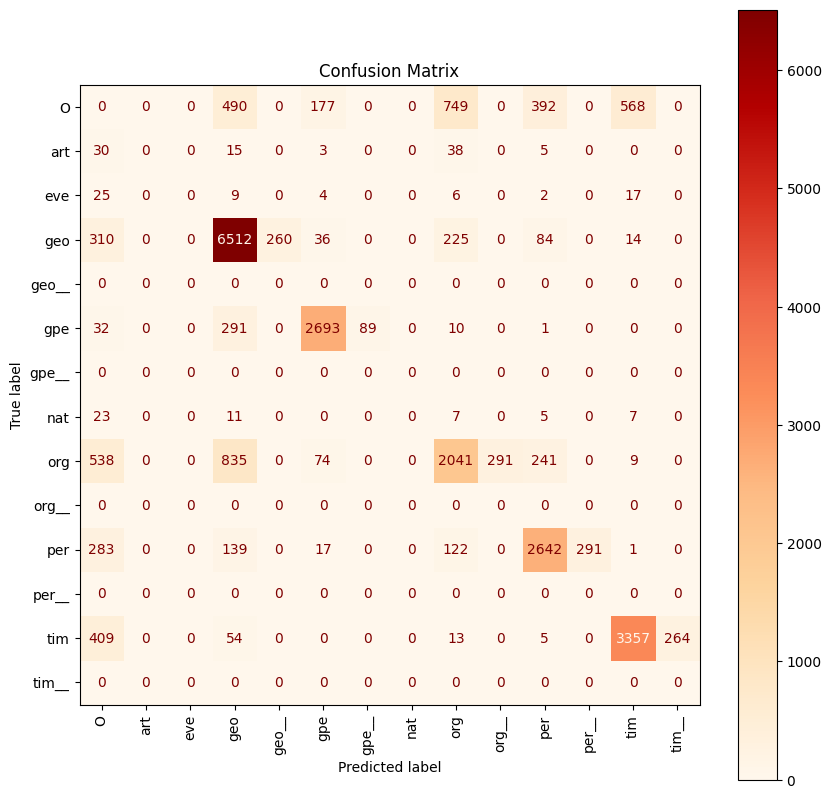

In [ ]:
plot_confusion_matrix(cm, cm_labels, show=True, save=False, img_path=None, normalize=None, decimal_places=2, figsize=(10,10), SMALL_SIZE=10, MEDIUM_SIZE=10, BIGGER_SIZE=12, cmap='OrRd', xticks_rotation='vertical', title='Confusion Matrix')

In [ ]:
model_save(model, 'ner_bert_model')

Saving model to: /content/drive/MyDrive/ds_data/NER/ner_bert_model


## SpaCy

spaCy features an extremely fast statistical entity recognition system, that assigns labels to contiguous spans of tokens. The default trained pipelines can identify a variety of named and numeric entities, including companies, locations, organizations and products.

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
sents = [df_full_sents['sentence'].iloc[i] for i in range(100)]

In [ ]:
doc = nlp(" ".join(sents))

In [ ]:
print('All entity types that spacy recognised from the 100 first sentences in dataset')
set([ent.label_ for ent in doc.ents])

All entity types that spacy recognised from the 100 first sentences in dataset


{'CARDINAL',
 'DATE',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERSON',
 'QUANTITY',
 'WORK_OF_ART'}

In [ ]:
print('Persons from the document above')
pprint(set([ent for ent in doc.ents if ent.label_ == 'PERSON']))
print('\n')
print('Organizations from the document above')
pprint(set([ent for ent in doc.ents if ent.label_ == 'ORG']))
print('\n')
print('Location names from the document above')
pprint(set([ent for ent in doc.ents if ent.label_ == 'LOC' or ent.label_ == 'GPE']))

Persons from the document above
{Mahmoud Ahmadinejad,
 Bilfinger Berger,
 Thomas Horbach,
 Abdullahi Yusuf Ahmad,
 Omar Khayam,
 Khayam,
 Khayam,
 Malik Faridullah Khan,
 Abdul Qadeer Khan,
 Khan,
 Halliburton,
 Nancy-Amelia Collins,
 Tim Harcourt,
 Mustafa Osman Ismail,
 Ismail,
 Khartoum,
 Bali,
 Java,
 Azahari bin Husin,
 Azahari bin Husin,
 Bali,
 Benedict,
 Orakzai}


Organizations from the document above
{the Houses of Parliament,
 Labor Party,
 The International Atomic Energy Agency,
 IAEA,
 The European Union,
 the U.N. Security Council,
 Delta State,
 Bayelsa State,
 Royal-Dutch Shell,
 Shell,
 al Qaida,
 al Qaida,
 Muslim Brotherhood,
 Brotherhood,
 Brotherhood,
 The Muslim Brotherhood,
 The Muslim Brotherhood,
 Islam,
 the British Home Office,
 Home Office,
 the Associated Press,
 AP,
 Kani Wam,
 al-Qaida,
 U.S. Army,
 APEC,
 VOA,
 the World Trade Organization 's,
 the APEC Business Advisory Council,
 the Australian Trade Commission,
 Harcourt,
 APEC,
 APEC,
 the Australian 

As we can see here the pre-trained spaCy model do good mainly but sometimes it confuses some words. For example, it marked  Khartoum, Bali, and Java as persons while they are geo-location, and the Sunni Arab and the Asia Pacific Economic Cooperation Business Advisory Council as geographical terms while they are organizations.

Let's look how we can visualize of SpaCy NER using `displacy` class from the same library:

In [ ]:
from spacy import displacy
displacy.render(doc, style="ent", jupyter=True)

#### Fine tuning SpaCy

Let's look if we could improve the performance that gives the default spaCy model by fine-tuning it on our corpus.

In [ ]:
from spacy.tokens import DocBin
from spacy.util import filter_spans
from tqdm import tqdm

nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin()

In [ ]:
df_gr.head()

,Word,POS,Tag
Sentence #,,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, through, London, to, protest, the, war, in, Iraq, and, demand, the, withdrawal, of, British, troops, from, that, country, .]","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, NN, IN, NNP, CC, VB, DT, NN, IN, JJ, NNS, IN, DT, NN, .]","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo, O, O, O, O, O, B-gpe, O, O, O, O, O]"
Sentence: 10,"[Iranian, officials, say, they, expect, to, get, access, to, sealed, sensitive, parts, of, the, plant, Wednesday, ,, after, an, IAEA, surveillance, system, begins, functioning, .]","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, JJ, NNS, IN, DT, NN, NNP, ,, IN, DT, NNP, NN, NN, VBZ, VBG, .]","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-tim, O, O, O, B-org, O, O, O, O, O]"
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, militant, hideouts, in, the, Orakzai, tribal, region, ,, where, many, Taliban, militants, are, believed, to, have, fled, to, avoid, an, earlier, military, offensive, in, nearby, South, Waziristan, .]","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, NN, ,, WRB, JJ, NNP, NNS, VBP, VBN, TO, VB, VBN, TO, VB, DT, JJR, JJ, NN, IN, JJ, NNP, NNP, .]","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O, O, B-org, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo, O]"
Sentence: 1000,"[They, left, after, a, tense, hour-long, standoff, with, riot, police, .]","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said, Sunday, ,, U.S., ,, Indonesian, and, Australian, military, helicopters, are, ferrying, out, food, and, supplies, to, remote, areas, of, western, Aceh, province, that, ground, crews, can, not, reach, .]","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, JJ, CC, JJ, JJ, NNS, VBP, VBG, RP, NN, CC, NNS, TO, VB, NNS, IN, JJ, NNP, NN, IN, NN, NNS, MD, RB, VB, .]","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo, O, B-gpe, O, B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O, O, O, O, O, O, O]"


Create a dictionary for mapping given NER tags with ones specific to the SpaCy:

In [ ]:
ne_tags_to_spacy = {
    'B-geo': 'GPE',
    'B-gpe': 'NORP',
    'B-per': 'PERSON',
    'I-geo': 'GPE',
    'B-org': 'ORG',
    'I-org': 'ORG',
    'B-tim': 'TIME',
    'I-per': 'PERSON',
    'I-gpe': 'NORP',
    'I-tim': 'TIME',
    'B-eve': 'EVENT',
    'I-eve': 'EVENT',
}

Function to prepare sentences from our corpus for the format needed to train SpaCy:

In [ ]:
def corpus_prepare(df):
  result = []

  for index, row in df.iterrows():
    sent = " ".join(row['Word'])
    entities = []
    for i in range(len(row['Tag'])):
      if row['Tag'][i] != 'O' and row['Tag'][i] in ne_tags_to_spacy:
        idx_start = 0
        for j in range(i):
            idx_start += len(row['Word'][j])
            if sent[idx_start] == " ":
                idx_start += 1

        idx_end = idx_start + len(row['Word'][i])
        entities.append(tuple([idx_start, idx_end, ne_tags_to_spacy[row['Tag'][i]]]))
    result.append({"text": sent, "entities": entities})

  return result

In [ ]:
corpus_prepare(df_gr[:3])

[{'text': 'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
  'entities': [(48, 54, 'GPE'), (77, 81, 'GPE'), (111, 118, 'NORP')]},
 {'text': 'Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .',
  'entities': [(0, 7, 'NORP'), (87, 96, 'TIME'), (108, 112, 'ORG')]},
 {'text': 'Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .',
  'entities': [(20, 28, 'TIME'),
   (62, 69, 'GPE'),
   (97, 104, 'ORG'),
   (190, 195, 'GPE'),
   (196, 206, 'GPE')]}]

In [ ]:
len(df_gr)

47959

In [ ]:
split_id = round(len(df_gr)*0.8)
split_id

38367

In [ ]:
train_df = df_gr[:split_id]
test_df = df_gr[split_id:]

In [ ]:
training_data = corpus_prepare(train_df)

In [ ]:
training_data[8]

{'text': 'Aid is being rushed to the region , but the U.N. official stressed that bottlenecks and a lack of infrastructure remain a challenge .',
 'entities': [(44, 48, 'GPE')]}

Converting training data into a binary format which is suitable for training the model:

In [ ]:
for training_example  in tqdm(training_data):
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents
    doc_bin.add(doc)

doc_bin.to_disk("train.spacy")

100%|██████████| 38367/38367 [00:08<00:00, 4365.34it/s]


Command to convert base_config created using the widget on the spacy website into the proper config which can be used for guiding the training process:

In [ ]:
!python -m spacy init fill-config /content/base_config.cfg config.cfg

2023-07-14 14:01:51.753639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Start training:

In [ ]:
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./train.spacy

2023-07-14 14:02:19.440320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: .
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
[2023-07-14 14:02:21,856] [INFO] Set up nlp object from config
[2023-07-14 14:02:21,873] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-07-14 14:02:21,876] [INFO] Created vocabulary
[2023-07-14 14:02:21,877] [INFO] Finished initializing nlp object
[2023-07-14 14:02:39,660] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     52.50    0.00    0.00    0.00    0.00
  0     200

Use the freshly trained model for inference:

In [ ]:
nlp_ner = spacy.load("model-last")

In [ ]:
!cp -r ./model-best/ ./drive/MyDrive/ds_data/NER/spacy/

In [ ]:
len(df_full_sents)

47959

In [ ]:
sents = [df_full_sents['sentence'].iloc[i] for i in range(40000, 40100)]
doc = nlp_ner(" ".join(sents))

Let's see how the model determine the different named entities classes:

In [ ]:
print('Persons from the testing set:')
print(set([ent for ent in doc.ents if ent.label_ == 'PERSON']))
print('\n')
print('Organizations from the testing set:')
print(set([ent for ent in doc.ents if ent.label_ == 'ORG']))
print('\n')
print('Location names from the testing set:')
print(set([ent for ent in doc.ents if ent.label_ == 'LOC' or ent.label_ == 'GPE']))

Persons from the testing set:
{Blanc, Murphy, Abed, Luis, Kohli, Saakashvili, al-Zarqawi, Ali, Philipp, Besigye, Google, Bush, Schoch, Museveni, Yoweri, Prommegger, Nogaideli, Ashraf, Musab, Abdul, Rashid, Daniela, Besigye, Mohammed, Abdullah, Bhatiasevi, Bush, Kamel, Sheikh, Besigye, Luis, Ursula, Kamel, Museveni, Mustafa, Abdalla, Shalabi, Abu, Museveni, Zurab, Bush, Meuli, Musharraf, Roh, Shadi, Razak, Zurab, Julie, Greg, Saakashvili, Inniger, David, Mr., al-Dagma, Bruno, Gollnisch, Chung, Ahmed, Moo-hyun, Schoch, Bruhin, Abu, General, Information, Heinz, Dhess, Vuitton, President, Mikhail, Ursula, Pervez, Mr., Vuitton, Djamel, President, Besigye, President, President, Saakashvili, Burdzhanadze, President, Minister, Mr., Nogaideli, Bruhin, Besigye, Pomagalski, President, President, Williams, Gollnisch, Mr., President, Kizza, Dong-young, Bruhin, President, Saleh, Nino, Isabelle, Andreas, Aphaluck, Vuitton, Ismail, Fraenzi, Schoch, Chung, Zhvania}


Organizations from the testing set:

In [ ]:
from spacy import displacy
displacy.render(doc, style="ent", jupyter=True)

As we can see my fine-tuned version of SpaCy assigns a tag to every single word in multi-word phrases while the original version assigns one label to that phrase. I think this was caused by the way I prepared training data, precisely because I specified the start/end indices of every tagged word separately, but probably should have united whole phrases under the single tag.
On the other hand, I would say that the correctness of labeling has improved. I hardly find bluntly wrong predictions.